In [1]:
# Import dependencies

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from google.colab import files 

In [2]:
# Load the file path

file_dir = '/content/drive/MyDrive/PlantVillage'
data = []
label = []

# Set the sixe of the image
size = 128

# Load the files in the path
for folders in os.listdir(file_dir):
    # print(folders) 
    for file in os.listdir(os.path.join(file_dir, folders)):
        if file.endswith("JPG"):
            label.append(folders)
            img = cv2.imread(os.path.join(file_dir, folders, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (size,size))
            data.append(im)
        else:
            continue

In [3]:
# Convert the data and labels to numpy arrays
data_arr = np.array(data)
label_arr = np.array(label)

In [4]:
# Categorize the label and data

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y,3)
X = data_arr/255
len(X)



2182

In [5]:
# Split the data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1745, 128, 128, 3), (437, 128, 128, 3), (1745, 3), (437, 3))

In [6]:
# Create the model

#tf.random.set_seed(42)

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(size, size, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [7]:
# Use umage data argumentation to produce more images

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         zoom_range = 0.20,
                                                         width_shift_range=0.3,
                                                         height_shift_range=0.3,
                                                         horizontal_flip=True,
                                                         vertical_flip=True)
datagen.fit(X_train)

In [8]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
batch_size=32
epochs=64
history = model.fit(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

Epoch 1/64
55/55 [==============================] - 19s 180ms/step - loss: 0.9489 - accuracy: 0.4653 - val_loss: 0.8537 - val_accuracy: 0.4600
Epoch 2/64
55/55 [==============================] - 7s 130ms/step - loss: 0.8231 - accuracy: 0.5989 - val_loss: 0.7823 - val_accuracy: 0.6568
Epoch 3/64
55/55 [==============================] - 9s 161ms/step - loss: 0.6542 - accuracy: 0.7358 - val_loss: 0.7160 - val_accuracy: 0.7254
Epoch 4/64
55/55 [==============================] - 8s 150ms/step - loss: 0.5580 - accuracy: 0.7994 - val_loss: 0.6807 - val_accuracy: 0.7208
Epoch 5/64
55/55 [==============================] - 8s 138ms/step - loss: 0.5114 - accuracy: 0.8241 - val_loss: 0.5931 - val_accuracy: 0.7849
Epoch 6/64
55/55 [==============================] - 9s 161ms/step - loss: 0.4199 - accuracy: 0.8527 - val_loss: 0.3733 - val_accuracy: 0.8490
Epoch 7/64
55/55 [==============================] - 7s 130ms/step - loss: 0.3447 - accuracy: 0.8768 - val_loss: 0.4863 - val_accuracy: 0.8238
Epoch

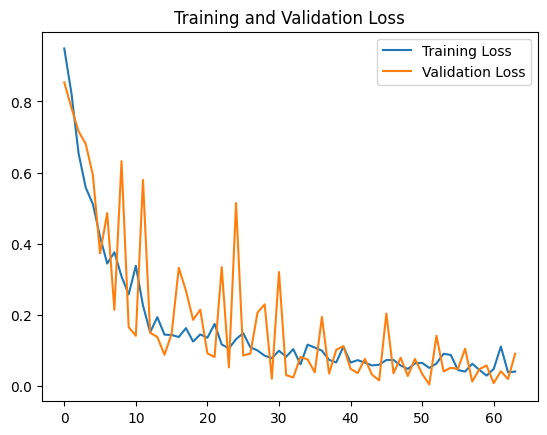

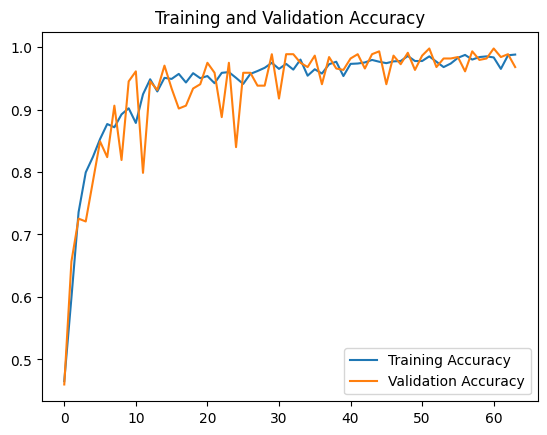

In [9]:
# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss values
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the training and validation accuracy values
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [12]:
# Visualizing the predicted class

categories = np.sort(os.listdir(file_dir))
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(size, size, 3), cmap='gray')
        else:
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(size, size, 3), cmap='gray')

Output hidden; open in https://colab.research.google.com to view.

In [16]:
from google.colab import drive
drive.mount('/content/drive')
# Train your TensorFlow model and save it to disk
model.save('model.h5')

# Copy the saved model file to Google Drive
import shutil
shutil.copy2('model.h5', '/content/drive/MyDrive/model.h5')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/model.h5'

In [17]:
print('Thank you for your time. God bless you')

Thank you for your time. God bless you
